<a href="https://colab.research.google.com/github/Pratichhya/Pratichhya.github.io/blob/master/docs/documents/hurricane_dsc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Assignment for the completion of Data Science and Machine Learning Course

### Course No. 20W856113

### Students -  Pratichhya Sharma(12031082)  and Tanya Singh(12031084)


## Objective 
1. Perform Basic Statistical Analysis 
2. Comparitive Analysis of Random Forest and Decision Tree Algorithm for classifying Status of Hurricane
3. Predicting Maximum Wind and Minimum Pressure for hurricane OPHELIA in next 24 hours using RNN
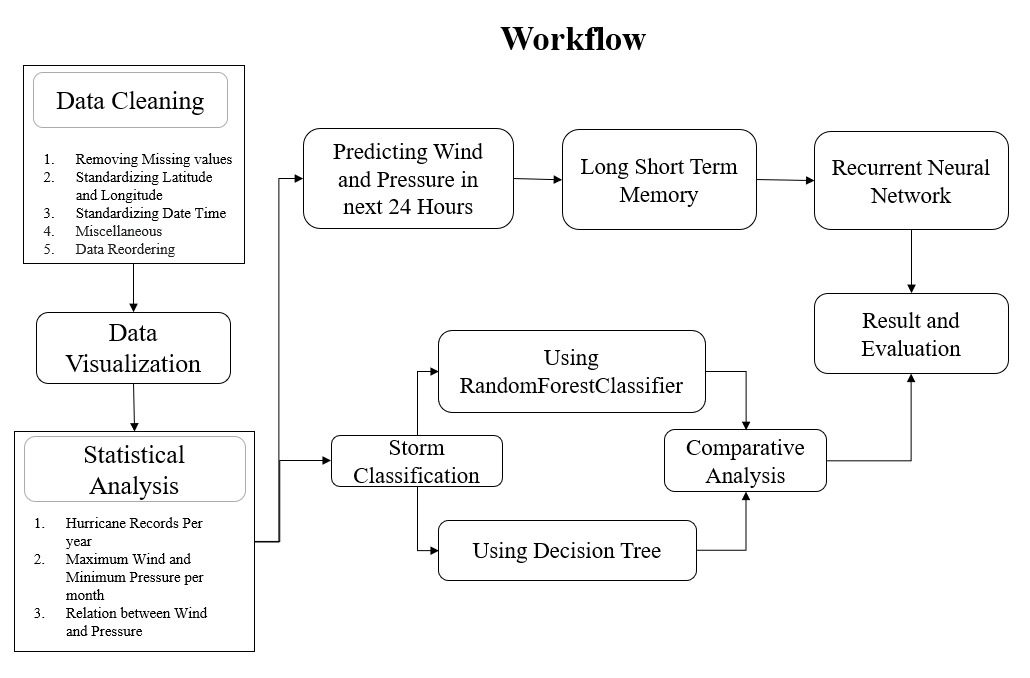

###  1. Importing Packages and Dataset

This data utilized in the study was provided as a part of course work of University of Salzburg. The data source is the revised Atlantic hurricane database (HURDAT2) - Chris Landsea, James Franklin, and Jack Beven – May 2015 - [data description](https://pratichhya.github.io/documents/dataset_des.pdf)

The task was completed in several sections that ranges from data cleaning, visualization, analysis, prediction and evaluation. For implementing Machine learning in this dataset, several python packages have been imported as per requirement


In [1]:
pip install cartopy

In [2]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sb
from matplotlib.animation import ArtistAnimation as aa
from IPython.display import HTML
import datetime

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, SimpleRNN

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/atlantic.csv")
data.head(10) #displaying initial 10 rows

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
5,AL011851,UNNAMED,18510626,0,,HU,28.2N,97.0W,70,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
6,AL011851,UNNAMED,18510626,600,,TS,28.3N,97.6W,60,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
7,AL011851,UNNAMED,18510626,1200,,TS,28.4N,98.3W,60,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
8,AL011851,UNNAMED,18510626,1800,,TS,28.6N,98.9W,50,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
9,AL011851,UNNAMED,18510627,0,,TS,29.0N,99.4W,50,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [4]:
print("The number of rows and columns for the initial data are :", data.shape)
print(" ")
print(data.describe())

The number of rows and columns for the initial data are : (49105, 22)
 
               Date          Time  ...  High Wind SW  High Wind NW
count  4.910500e+04  49105.000000  ...  49105.000000  49105.000000
mean   1.949802e+07    910.125975  ...   -877.923552   -877.786295
std    4.461850e+05    671.043363  ...    327.021430    327.408253
min    1.851062e+07      0.000000  ...   -999.000000   -999.000000
25%    1.911110e+07    600.000000  ...   -999.000000   -999.000000
50%    1.956093e+07   1200.000000  ...   -999.000000   -999.000000
75%    1.989081e+07   1800.000000  ...   -999.000000   -999.000000
max    2.015111e+07   2330.000000  ...    150.000000    180.000000

[8 rows x 16 columns]


From the initial observation of the data we can make out there are many missing values saved as -999 and -99, and the format of date and time also needs to be changed. These and many data cleaning methods will be performed in the following sections

### 2. Data Cleaning



### 2.1 Identifying and removing missing values

In [5]:
#converting all columns to string
dataList = list(data)
data[dataList] = data[dataList].astype(str)

# converting -999 and -99 as NaN
data = data.replace("-999" , np.NaN)
data = data.replace ("-99" , np.NaN)

#droping rows where atleast one element is missing
data = data.dropna()

#checking if any missing value is left
check = data.isnull()

### 2.2 Standardising Latitude and Longitude
The N/S/E/W tags needs to be removed for the Latitude and Longitude, and the datatype should be changed to numeric so as to fascilitate their usage in further analyses. Moreover, a minus sign needs to be added to the longitude values as they represent the western hemisphere. This was followed by the process of checking for outliers in the values of these attributes.

In [6]:
#removing N, S, E, W hemisphere tags from coordinates
data["Longitude"] = data["Longitude"].map(lambda x: x.rstrip("W"))
data["Latitude"] = data["Latitude"].map(lambda x: x.rstrip("N"))
data["Latitude"] = data["Latitude"].map(lambda x: x.rstrip("S"))
data["Longitude"] = data["Longitude"].map(lambda x: x.rstrip("E"))

In [7]:
#converting datatype of lat long from string to float
data["Latitude"]= pd.to_numeric(data["Latitude"], downcast = "float")
data["Longitude"]= pd.to_numeric(data["Longitude"], downcast = "float")

#adding "-" to longitude
data["Longitude"] = (data["Longitude"] * -1)

Latitude max value:  69.0
Latitude min value:  8.300000190734863


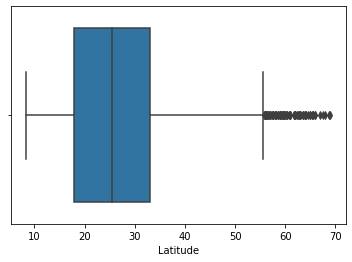

In [8]:
# checking for outliers in latitude
lat = data["Latitude"]
sb.boxplot(x=lat)
print("Latitude max value: ", lat.max())
print("Latitude min value: ", lat.min())

From the box-plot results we can infer that there are no anomalous outliers

Longitude max value:  -0.0
Longitude min value:  -106.69999694824219


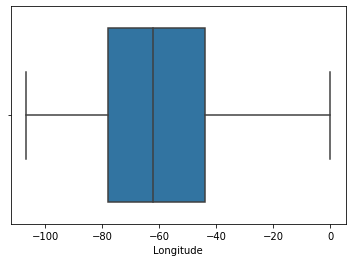

In [9]:
# checking outliers in longitude
long = data["Longitude"]
sb.boxplot(x= long)
print("Longitude max value: ", long.max())
print("Longitude min value: ", long.min())

### 2.3 Standardising Date and Time
The Time and Date column needs to concatenated according to the the ISO-8601 standard (Year-month-date-hour-minutes-second). To achieve this the time column was standardized to four figure unit by adding 0s infront of the data values. Furthurmore, we updated the format of Date, and made seperate Year and Month columns, which will be used in other sections.  

In [10]:
# Adding Time stamp to the DataFrame

#lambda function for adding zeros to Time
new_time = data["Time"].apply(lambda x: "{0:0>4}".format(x))
data["Time_Stamp"] = new_time


# Concatenating time and date 
timestamp = data["Date"]+ data["Time_Stamp"].astype(str)
timestamp_column = []

#updating timestamp according to ISO-8601
for x in timestamp:
    x_datetime = datetime.datetime.strptime(x, "%Y%m%d%H%M%S")
    timestamp_column.append(x_datetime)
    
#The new timestamp column
data["Timestamp"] = timestamp_column

#changing format of date
data["Date"] = pd.to_datetime(data["Date"], format = "%Y %m %d")

# adding year and month column for specific task
data["Year"] = data["Date"].map(lambda x : x.year)
data["Month"] = data["Date"].map(lambda x : x.month)

#removing the original time columns
data.drop("Time", axis ="columns", inplace = True)
data.drop("Time_Stamp", axis ="columns", inplace = True)

### 2.4 Miscellaneous
This section consists of additional data cleaning tasks such as removing unnecessary spaces in the event column and removing duplicate values in the DataFrame.

In [11]:
# Checking status column
old=pd.unique(data["Event"])
print(old)
# removing space before characters in column event
data["Event"] = data["Event"].replace([" L", " I", " S", " G", " W", " T", " P"], ["L", "I", "S", "G", "W", "T", "P"])
new= pd.unique(data["Event"])
print(new)

['  ' ' L' ' I' ' S' ' G' ' W' ' T' ' P']
['  ' 'L' 'I' 'S' 'G' 'W' 'T' 'P']


In [12]:
#checking for duplicate values
duplicate = data.duplicated(subset=None, keep ="first")
duplicateList = duplicate.tolist()

n=0 # counter for duplicate values

for i in duplicateList:
    if i == "True":
        n=n+1 
        
print("Number of duplicate values: ", n)

Number of duplicate values:  0


### 2.5 Data Reordering

In [13]:
data = data[["ID", "Name", "Timestamp", "Latitude", "Longitude", "Status","Event","Maximum Wind", "Minimum Pressure","Low Wind NE", "Low Wind SE", "Low Wind SW", "Low Wind NW",
       "Moderate Wind NE","Moderate Wind SE", "Moderate Wind SW","Moderate Wind NW", "High Wind NE", "High Wind SE", "High Wind SW",
       "High Wind NW", "Date", "Year", "Month"]]
data

,ID,Name,Timestamp,Latitude,Longitude,Status,Event,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Date,Year,Month
43104,AL012004,ALEX,2004-07-31 18:00:00,30.299999,-78.300003,TD,,25,1010,0,0,0,0,0,0,0,0,0,0,0,0,2004-07-31,2004,7
43105,AL012004,ALEX,2004-08-01 00:00:00,31.000000,-78.800003,TD,,25,1009,0,0,0,0,0,0,0,0,0,0,0,0,2004-08-01,2004,8
43106,AL012004,ALEX,2004-08-01 06:00:00,31.500000,-79.000000,TD,,25,1009,0,0,0,0,0,0,0,0,0,0,0,0,2004-08-01,2004,8
43107,AL012004,ALEX,2004-08-01 12:00:00,31.600000,-79.099998,TD,,30,1009,0,0,0,0,0,0,0,0,0,0,0,0,2004-08-01,2004,8
43108,AL012004,ALEX,2004-08-01 18:00:00,31.600000,-79.199997,TS,,35,1009,0,50,50,0,0,0,0,0,0,0,0,0,2004-08-01,2004,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,2015-11-12 12:00:00,41.299999,-50.400002,EX,,55,981,220,220,180,120,120,120,60,0,0,0,0,0,2015-11-12,2015,11
49101,AL122015,KATE,2015-11-12 18:00:00,41.900002,-49.900002,EX,,55,983,220,220,180,120,120,120,60,0,0,0,0,0,2015-11-12,2015,11
49102,AL122015,KATE,2015-11-13 00:00:00,41.500000,-49.200001,EX,,50,985,540,520,200,220,120,120,60,0,0,0,0,0,2015-11-13,2015,11
49103,AL122015,KATE,2015-11-13 06:00:00,40.799999,-47.500000,EX,,45,985,620,460,180,220,0,0,0,0,0,0,0,0,2015-11-13,2015,11


A qualitative dataset for analysis was assembled after removing the null values but the amount of dataset was reduced drastically when trying to meet the specific criteria.The initial dataset was reduced to 5921 rows (records) and 22 columns (attribute), with records available from 2004 to 2015.

### 3. Data Visualization 
Here, the movement of the hurricanes was vizualized using libraries from the cartopy package.  Additionally, a HTML representation of the hurricane movement was generated using 'Artistic Animation', through 2004 to 2015. Each hurricane was given a seperate color for a meaningful visualization.

In [ ]:
#to set single color for each hurricane based on name
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
model_colors ={}
for i, model in enumerate(data["Name"].unique()):
    model_colors[model] = colors[i%10]

#spatial projection
map_crs = ccrs.LambertConformal(central_latitude = 45, central_longitude = -80)

#coordinate reference system
data_crs = ccrs.PlateCarree() 

# plotting base map
fig = plt.figure(figsize = (17,12))
ax = plt.subplot(111,projection = map_crs)
ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth = 0.75) #to show the coastline

#ploting based on time stamp
artists = []
for d in data["Date"].unique():
    text = ax.text(0.5,1.02,f'Recorded {d}',ha ="center", transform = ax.transAxes, fontsize =24)
    timestep_artist = [text]
    time_df = data.loc[data["Date"] == d]
    
    #targeting one hurricane at a time
    for name in time_df["Name"].unique():
        name_path = time_df.loc[time_df["Name"]==name]
        s = ax.scatter(name_path["Longitude"], name_path["Latitude"], alpha = 0.5, transform = data_crs, color = model_colors[name])# scatter plot
        timestep_artist.append(s)
    artists.append(timestep_artist)
    #setting extent of plot
    ax.set_extent([-107, 1, 6, 70], crs = data_crs)

Geometry must be a Point or LineString


In [ ]:
#creating a animation video

plt.rcParams["animation.embed_limit"] = 2**128
anim = aa(fig,artists,interval = 100 )# time interval is 1 sec per frame
HTML(anim.to_jshtml())

### 4. Statistical Analysis

### 4.1 Hurricane record

Text(0, 0.5, 'Number')

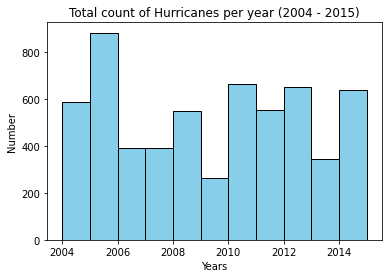

In [14]:
# Total hurricane record per year (2004 to 2015)

count = data["Year"].value_counts()
count_data = pd.DataFrame(count)
count_data = count_data.reset_index()
count_data = count_data.rename(columns={"index": "Year", "Year": "Total"})
count_data = count_data.sort_values(by = "Year", ascending = True)

#plot histogram
plt.hist(data["Year"], color = "skyblue", edgecolor = "black", bins = 11)
# Labels
plt.title("Total count of Hurricanes per year (2004 - 2015)")
plt.xlabel("Years")
plt.ylabel("Number")